# 05: Annotation Pipeline (LLM 标注流程)

步骤：加载话题数据 → 映射用户类型 → 调用 LLMAnnotator 标注情绪/风险 → 保存标注结果并汇总统计。


In [2]:
from pathlib import Path
import sys
import json
import random
import pandas as pd  # 需要已安装 pandas
from tqdm import tqdm

# 路径与导入设置：确保能找到 src 模块
ROOT = Path("..").resolve()  # notebook 位于 notebooks/ 下
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.empirical import LLMAnnotator, load_topic_dataset, preprocess_weibo_text, is_valid_for_annotation

# LLM 配置（请根据实际修改）
BASE_URL = "http://10.13.12.164:7890/v1"  # Qwen 端点
API_KEY = "abc123"  # 替换为实际 key
MODEL_NAME = "Qwen/Qwen3-8B"

# 数据路径与输出路径
DATA_PATH = ROOT / "dataset/Topic_data/#新冠后遗症#_filtered.csv"
ANNOT_PATH = ROOT / "outputs/annotations/annotated_sample.jsonl"
ANNOT_PATH.parent.mkdir(parents=True, exist_ok=True)

df = load_topic_dataset(DATA_PATH)

# 采样设置
SAMPLE_SIZE = df.shape[0]  # 调试时可先标注少量
SEED = 42
random.seed(SEED)

# 初始化标注器
ann = LLMAnnotator(
    provider="openai",
    api_key=API_KEY,
    model=MODEL_NAME,
    base_url=BASE_URL,
)


In [3]:
# 1) 加载数据并映射用户类型
print("rows:", len(df))
print(df.head())

# 2) 预处理：清洗文本、过滤无效样本
raw_texts = df["content"].dropna().tolist()
print(f"原始文本数: {len(raw_texts)}")

# 预处理并过滤
preprocessed = []
for t in raw_texts:
    clean = preprocess_weibo_text(t, max_length=500)
    if is_valid_for_annotation(clean, min_length=5):
        preprocessed.append((t, clean))  # 保留原文和清洗后文本

print(f"有效文本数: {len(preprocessed)}")

# 采样（从预处理后的有效文本中采样）
if SAMPLE_SIZE and len(preprocessed) > SAMPLE_SIZE:
    preprocessed = random.sample(preprocessed, SAMPLE_SIZE)
print(f"采样数: {len(preprocessed)}")

# 展示预处理效果
print("\n--- 预处理效果示例 ---")
for i, (orig, clean) in enumerate(preprocessed[:3]):
    print(f"\n[样本 {i+1}]")
    print(f"原文: {orig[:100]}...")
    print(f"清洗后: {clean[:100]}...")


rows: 6195
                mid     user_name                     user_link verify_typ  \
0  4486346854783576      lemon丶66  https://weibo.com/6148776898       没有认证   
1  4501186348492875        长弓白石文王  https://weibo.com/1443422847       没有认证   
2  4504565208086027  澳洲微报AuweNews  https://weibo.com/6329108384       黄V认证   
3  4504804603450936           视角志  https://weibo.com/5597141810       黄V认证   
4  4526255074129559    北京众成医疗律师团队  https://weibo.com/1448448401       没有认证   

                               weibo_link        publish_time  \
0  https://weibo.com/6148776898/IAeh7k4qs 2020-03-25 12:51:00   
1  https://weibo.com/1443422847/J0uRszDnR 2020-05-05 11:38:00   
2  https://weibo.com/6329108384/J1ULexVxN 2020-05-14 19:24:00   
3  https://weibo.com/5597141810/J20ZmetKg 2020-05-15 11:16:00   
4  https://weibo.com/1448448401/Jb10ThkhN 2020-07-13 15:52:00   

                                             content  \
0       搜了一下新冠后遗症，相关的东西很少，希望就像说的那样，别像非典后遗症那样吧#新冠后遗症#   
1  有出入证，各项都正常，又一次

In [4]:
# 3) 逐条调用 LLM 标注（使用清洗后的文本，保存原文用于参考）
results = []
with ANNOT_PATH.open("w", encoding="utf-8") as f:
    for orig, clean in tqdm(preprocessed, desc="annotating"):
        # 使用清洗后的文本进行标注
        res = ann.annotate(clean, max_tokens=1024)
        
        # 保存时记录原文和清洗后文本
        result_dict = res.to_dict()
        result_dict["original_text"] = orig  # 原文
        result_dict["text"] = clean  # 清洗后文本（覆盖）
        
        results.append(res)
        f.write(json.dumps(result_dict, ensure_ascii=False) + "\n")

print("done, saved to", ANNOT_PATH)


annotating: 100%|██████████| 6143/6143 [4:22:47<00:00,  2.57s/it]       

done, saved to E:\newdesktop\emotion_dynamics\outputs\annotations\annotated_sample.jsonl


In [5]:
# 4) 汇总统计（情绪/风险分布）
import pandas as pd

# 从文件重新加载（确保包含所有字段）
df_ann = pd.read_json(ANNOT_PATH, lines=True)
print(df_ann.head())

print("\n=== 标注结果统计 ===")
print("\n情绪分布:")
print(df_ann["emotion_class"].value_counts(normalize=True))
print("\n风险分布:")
print(df_ann["risk_class"].value_counts(normalize=True))

# 交叉统计
print("\n=== 情绪 × 风险 交叉表 ===")
print(pd.crosstab(df_ann["emotion_class"], df_ann["risk_class"], normalize='all').round(3))



                                                text emotion_class risk_class  \
0      #新冠后遗症# 搜了一下新冠后遗症，相关的东西很少，希望就像说的那样，别像非典后遗症那样吧             L       risk   
1  #新冠后遗症# 有出入证，各项都正常，又一次被告知自行车不让进村，南门不让进，但是北门让进(...             L     norisk   
2  #新冠后遗症# 目前，全球已经有超过430万人感染了新冠病毒。因新冠病毒离世的病患，更是超出...             M       risk   
3  #新冠后遗症# 【美国遭儿童流行病警报 或与有关】日前，美国波士顿儿科医院的医生，进行了一项...             M       risk   
4  #新冠后遗症# #新冠肺炎# #新冠肺炎并发症# 肺炎 【武汉医生：爸妈感染新冠，半年了后...             H       risk   

   emotion_confidence  risk_confidence  \
0                0.70             0.80   
1                0.70             0.90   
2                0.80             0.95   
3                0.95             0.98   
4                0.95             0.98   

                                           reasoning  \
0  情绪表达为担忧和不安，提及非典后遗症暗示对新冠后遗症的潜在风险担忧。内容涉及后遗症讨论，符合...   
1  情绪表达为无奈和迷茫，未提及新冠身体症状或后遗症，讨论的是防疫政策执行问题，属于社会管理话题...   
2  情绪表达较为理性，陈述事实和数据，未使用强烈情绪词汇。内容提及新冠后遗症及患者病痛，符合风险...   
3  情绪上为中性理性讨论，无强烈情绪词汇。风险信息明确描述新冠后遗症（

In [6]:
print("Figures saved to", Path("outputs/figs"))
print("Annotations saved to", ANNOT_PATH)
print("Data cached in", Path("outputs/data"))


Figures saved to outputs\figs
Annotations saved to E:\newdesktop\emotion_dynamics\outputs\annotations\annotated_sample.jsonl
Data cached in outputs\data


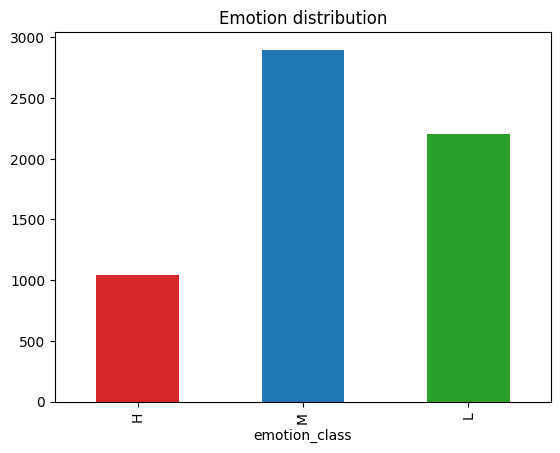

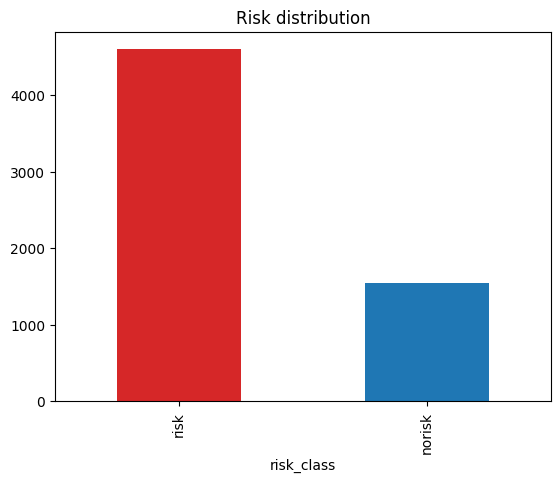

In [7]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

# 兼容单独运行：若未定义 ROOT/ANNOT_PATH，则回退到 notebooks/..
if 'ROOT' not in globals():
    ROOT = Path('..').resolve()
if 'ANNOT_PATH' not in globals():
    ANNOT_PATH = ROOT / 'outputs/annotations/annotated_sample.jsonl'

FIG_DIR = ROOT / 'outputs/figs'
FIG_DIR.mkdir(parents=True, exist_ok=True)

# 读取标注结果
df_ann = pd.read_json(ANNOT_PATH, lines=True)

# 情绪分布
fig, ax = plt.subplots()
df_ann['emotion_class'].value_counts().reindex(['H', 'M', 'L']).plot(
    kind='bar',
    ax=ax,
    color=['#d62728', '#1f77b4', '#2ca02c'],
)
ax.set_title('Emotion distribution')
fig.savefig(FIG_DIR / 'fig5_emotion_dist.png', dpi=200)

# 风险分布
fig, ax = plt.subplots()
df_ann['risk_class'].value_counts().reindex(['risk', 'norisk']).plot(
    kind='bar',
    ax=ax,
    color=['#d62728', '#1f77b4'],
)
ax.set_title('Risk distribution')
fig.savefig(FIG_DIR / 'fig5_risk_dist.png', dpi=200)
plt.show()
